# 06. Transfer Learning in TensorFlow Part 3: Scaling-up Exercises

### 1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import zipfile
from extras.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix

%matplotlib inline

In [6]:
# Download pre-trained model (one that was prepared earlier, so that all predictions are similar)
!curl "https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip" --output "../Models/Classification_with_Tensorflow/06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data("../Models/Classification_with_Tensorflow/06_101_food_class_10_percent_saved_big_dog_model.zip")
# Load in the saved model
down_model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 44.5M    0  4735    0     0   4133      0  3:08:33  0:00:01  3:08:32  4142
  1 44.5M    1  556k    0     0   458k      0  0:01:39  0:00:01  0:01:38  458k
 15 44.5M   15 6864k    0     0  3096k      0  0:00:14  0:00:02  0:00:12 3098k
 37 44.5M   37 16.5M    0     0  5279k      0  0:00:08  0:00:03  0:00:05 5281k
 61 44.5M   61 27.3M    0     0  6642k      0  0:00:06  0:00:04  0:00:02 6644k
 86 44.5M   86 38.3M    0     0  7531k      0  0:00:06  0:00:05  0:00:01 9647k
100 44.5M  100 44.5M    0     0  7851k      0  0:00:05  0:00:05 --:--:-- 9806k


In [23]:
image_files = [img_path for img_path in os.listdir("../extras/Artifacts") if ".jpg" in img_path]
print(image_files)

['donuts.jpg', 'edamame.jpg', 'pizza.jpg']


In [11]:
class_names = os.listdir("../Data/Classification/101_food_classes_10_percent/train")

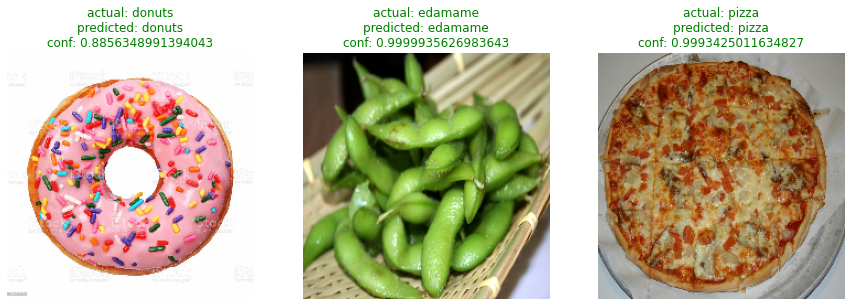

In [26]:
# now basically all we need to is predict and display
import math
def predict_and_plot(image_files, model, class_names, img_size = 224, figsize = (15,15), num_cols = 3):
    """
    """
    num_rows = math.ceil(len(image_files)/num_cols)
    plt.figure(figsize=figsize)
    for row, imgfile in enumerate(image_files):
        filepath = f"../extras/Artifacts/{imgfile}"
        img = tf.io.read_file(filepath)
        img = tf.io.decode_image(img, channels = 3)
        img = tf.image.resize(img, size = (img_size, img_size))
        pred_prob = model.predict(tf.expand_dims(img, axis = 0), verbose = 0)
        plt.subplot(num_rows, num_cols, row + 1)
        class_name = class_names[tf.argmax(pred_prob, axis = 1).numpy()[0]]
        ground_truth = imgfile.replace(".jpg", "")
        plt.imshow(img/255.)
        if class_name == ground_truth:
            plt.title(f"actual: {ground_truth}\npredicted: {class_name}\nconf: {tf.reduce_max(pred_prob)}", color = "green")
        else:
            plt.title(f"actual: {ground_truth}\npredicted: {class_name}\nconf: {tf.reduce_max(pred_prob)}", color = "red")
        plt.axis(False)

predict_and_plot(image_files, down_model, class_names)

### 2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

In [29]:
train_dir = "../Data/Classification/101_food_classes_10_percent/train"
test_dir = "../Data/Classification/101_food_classes_10_percent/test"
IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode = "categorical", image_size = IMG_SHAPE, batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode = "categorical", image_size = IMG_SHAPE, batch_size=BATCH_SIZE)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [30]:
data_augmentation_layer = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
        tf.keras.layers.experimental.preprocessing.RandomHeight(0.1),
        tf.keras.layers.experimental.preprocessing.RandomWidth(0.1),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)
    ], name = "data_augmentation_layer"
)

In [31]:
# Get the base model efficientnetb0
effnetb0 = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
effnetb0.trainable = False

# Build the model
inputs = tf.keras.layers.Input(shape = IMG_SHAPE+(3,), name = "input_layer")

# data augmentation
x = data_augmentation_layer(inputs)

# Base model
x = effnetb0(x, training = False)

# Global Average Pooling
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layers")(x)

# Generate output
outputs = tf.keras.layers.Dense(len(train_data.class_names), activation = "softmax", name = "output_layer")(x)

model = tf.keras.Model(inputs, outputs, name = "model")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 rs (GlobalAveragePooling2D)                                     
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [32]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(), 
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Fit the model
history_model = model.fit(
    train_data,
    epochs = 10,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data))
)

Epoch 1/10
237/237 [==============================] - 142s 523ms/step - loss: 3.2560 - accuracy: 0.3022 - precision: 0.9582 - recall: 0.0302 - val_loss: 2.2303 - val_accuracy: 0.4947 - val_precision: 0.9576 - val_recall: 0.1197
Epoch 2/10
237/237 [==============================] - 67s 280ms/step - loss: 2.0355 - accuracy: 0.5401 - precision: 0.9444 - recall: 0.1773 - val_loss: 1.8209 - val_accuracy: 0.5511 - val_precision: 0.8924 - val_recall: 0.2503
Epoch 3/10
237/237 [==============================] - 59s 246ms/step - loss: 1.6515 - accuracy: 0.6161 - precision: 0.9385 - recall: 0.2902 - val_loss: 1.6612 - val_accuracy: 0.5749 - val_precision: 0.8707 - val_recall: 0.3371
Epoch 4/10
237/237 [==============================] - 58s 243ms/step - loss: 1.4261 - accuracy: 0.6599 - precision: 0.9364 - recall: 0.3750 - val_loss: 1.5828 - val_accuracy: 0.5821 - val_precision: 0.8551 - val_recall: 0.3750
Epoch 5/10
237/237 [==============================] - 55s 232ms/step - loss: 1.2630 - accur

In [33]:
results_feature_ext_model_10 = model.evaluate(test_data)
results_feature_ext_model_10

790/790 [==============================] - 76s 96ms/step - loss: 1.4781 - accuracy: 0.6031 - precision: 0.8060 - recall: 0.4663


[1.4781352281570435,
 0.6031287312507629,
 0.8059834241867065,
 0.4662574231624603]

In [34]:
results_fine_tune_model = down_model.evaluate(test_data)
results_fine_tune_model

790/790 [==============================] - 81s 100ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027218580245972, 0.6077623963356018]

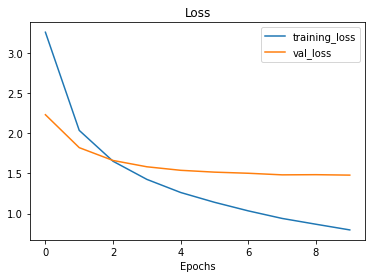

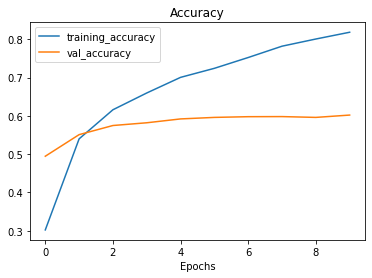

In [35]:
plot_loss_curves(history_model)

Look at that overfitting baby!

### 3. Recreate the first model (the feature extraction model) with mixed_precision turned on.

In [38]:
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.set_global_policy(policy)

In [40]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(), 
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Fit the model
history_model_final = model.fit(
    train_data,
    epochs = 10,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data))
)

Epoch 1/10
237/237 [==============================] - 51s 190ms/step - loss: 0.7513 - accuracy: 0.8309 - precision_1: 0.9611 - recall_1: 0.6396 - val_loss: 1.4928 - val_accuracy: 0.5953 - val_precision_1: 0.7842 - val_recall_1: 0.4746
Epoch 2/10
237/237 [==============================] - 48s 202ms/step - loss: 0.6897 - accuracy: 0.8455 - precision_1: 0.9653 - recall_1: 0.6690 - val_loss: 1.4962 - val_accuracy: 0.5985 - val_precision_1: 0.7786 - val_recall_1: 0.4844
Epoch 3/10
237/237 [==============================] - 47s 195ms/step - loss: 0.6279 - accuracy: 0.8648 - precision_1: 0.9691 - recall_1: 0.7009 - val_loss: 1.5129 - val_accuracy: 0.5953 - val_precision_1: 0.7728 - val_recall_1: 0.4854
Epoch 4/10
237/237 [==============================] - 48s 203ms/step - loss: 0.5877 - accuracy: 0.8759 - precision_1: 0.9679 - recall_1: 0.7208 - val_loss: 1.5119 - val_accuracy: 0.5972 - val_precision_1: 0.7703 - val_recall_1: 0.4910
Epoch 5/10
237/237 [==============================] - 48s 20

Look at that speed! Its amazing how much we could have sped up training just by going from 32 bit floating point representation to 16 bit floating point representation.

And that concludes the exercises for this section. Whew! That took a while.